# ACT EPA Visualizations

This notebook demonstrates visualizations for EPA representations:

1. **t-SNE** - Cluster visualization in early/late layers (Figure 14 style)
2. **LAT Scans** - Temporal activation across layers (Figure 8 style)
3. **Per-Token Detection** - Token-level EPA intensity (Figure 9 style)

## Setup

In [1]:
import sys
sys.path.append('../..')

import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.colors import Normalize, LinearSegmentedColormap

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from repe import repe_pipeline_registry

repe_pipeline_registry()

from utils import (
    format_llama3_prompt,
    format_for_reading,
    create_all_epa_datasets,
    EPA_DIMENSIONS,
    plot_tsne_epa,
    plot_lat_scan,
    plot_per_token_detection,
)

c:\Users\Kyra\mambaforge-pypy3\envs\repeng\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model
model_name = "meta-llama/Llama-3.1-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

rep_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

print(f"Model: {model_name}")
print(f"Layers: {model.config.num_hidden_layers}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]
Device set to use cuda:0


Model: meta-llama/Llama-3.1-8B-Instruct
Layers: 32


In [3]:
# Load EPA directions
with open("epa_directions.pkl", 'rb') as f:
    epa_data = pickle.load(f)

rep_readers = epa_data['rep_readers']
hidden_layers = epa_data['hidden_layers']

print(f"Loaded: {list(rep_readers.keys())}")

Loaded: ['evaluation', 'potency', 'activity']


---
## 1. t-SNE Visualization (Figure 14 Style)

Visualize how EPA representations cluster in early vs late layers.

In [4]:
# Create dataset for visualization
data_dir = "../../data/act"
datasets = create_all_epa_datasets(data_dir, n_train=100, seed=42)

In [5]:
# Get raw hidden states for each dimension
def get_separated_hidden_states(dimension, n_samples=50):
    """Get hidden states separated by positive/negative class."""
    data = datasets[dimension]
    
    # Get hidden states
    hidden_states = rep_pipeline(
        data['train']['data'][:n_samples*2],
        hidden_layers=hidden_layers,
        rep_reader=None,
        batch_size=8,
        padding=True,
        truncation=True,
    )
    
    # Separate by label
    pos_states = {layer: [] for layer in hidden_layers}
    neg_states = {layer: [] for layer in hidden_layers}
    
    for i, h in enumerate(hidden_states):
        pair_idx = i // 2
        in_pair_idx = i % 2
        
        if pair_idx >= len(data['train']['labels']):
            break
            
        is_positive = data['train']['labels'][pair_idx][in_pair_idx]
        
        for layer in hidden_layers:
            if layer in h:
                if is_positive:
                    pos_states[layer].append(h[layer])
                else:
                    neg_states[layer].append(h[layer])
    
    return pos_states, neg_states

Processing evaluation...
Processing potency...
Processing activity...


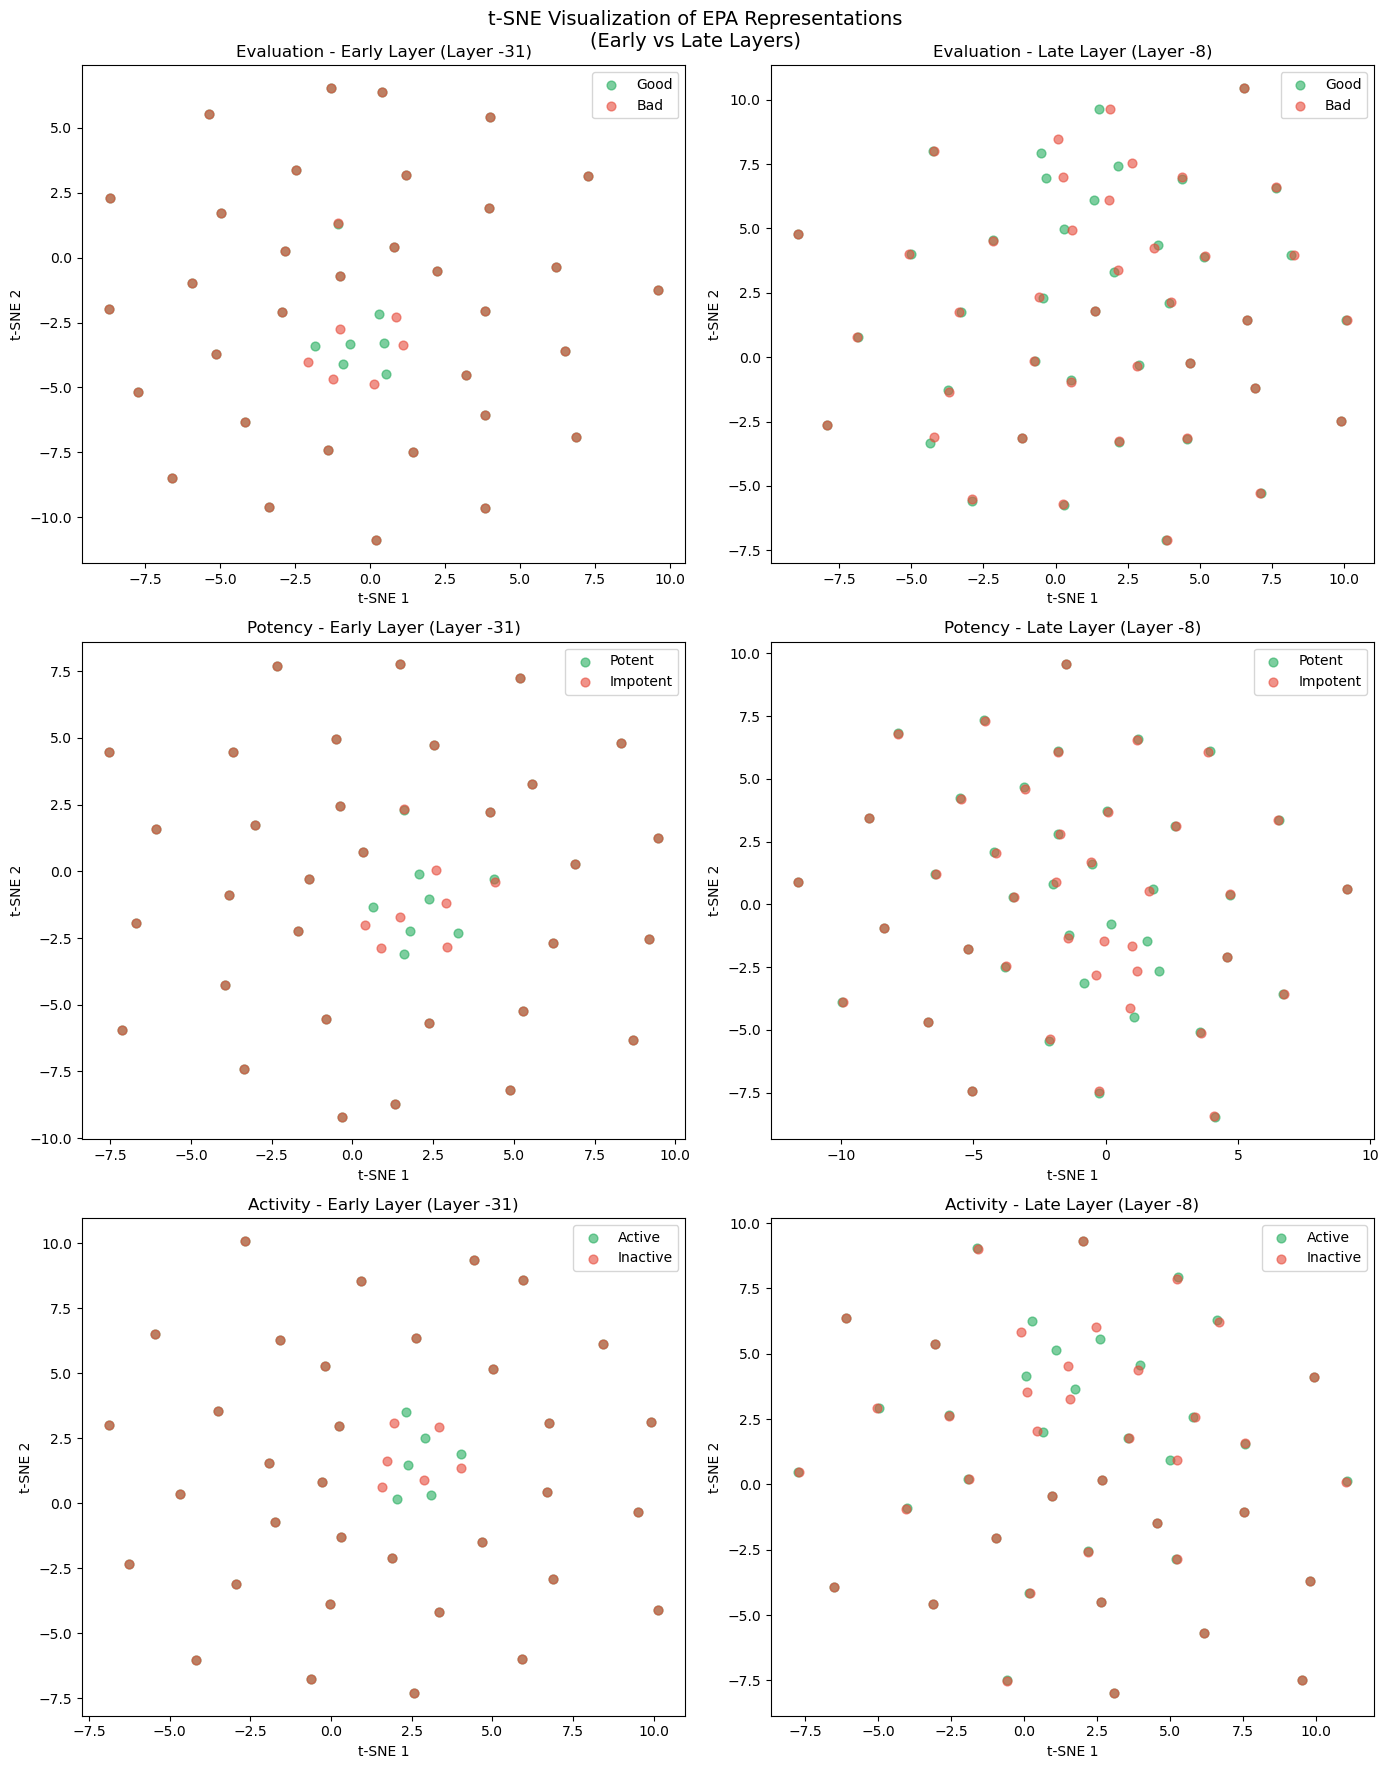

In [6]:
# Create t-SNE visualizations for all dimensions
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

early_layer = hidden_layers[-1]  # Later in list = earlier in model (negative indexing)
late_layer = hidden_layers[len(hidden_layers)//4]  # Earlier in list = later in model

for row, dimension in enumerate(["evaluation", "potency", "activity"]):
    print(f"Processing {dimension}...")
    pos_states, neg_states = get_separated_hidden_states(dimension)
    
    for col, (layer, title) in enumerate([(early_layer, "Early Layer"), (late_layer, "Late Layer")]):
        ax = axes[row, col]
        
        if pos_states[layer] and neg_states[layer]:
            pos_arr = np.vstack(pos_states[layer][:40])
            neg_arr = np.vstack(neg_states[layer][:40])
            all_states = np.vstack([pos_arr, neg_arr])
            
            # t-SNE
            tsne = TSNE(n_components=2, perplexity=min(30, len(all_states)-1), random_state=42)
            embedded = tsne.fit_transform(all_states)
            
            # Plot
            dim_info = EPA_DIMENSIONS[dimension]
            ax.scatter(embedded[:len(pos_arr), 0], embedded[:len(pos_arr), 1],
                      c='#27ae60', label=dim_info['positive'].capitalize(), alpha=0.6, s=40)
            ax.scatter(embedded[len(pos_arr):, 0], embedded[len(pos_arr):, 1],
                      c='#e74c3c', label=dim_info['negative'].capitalize(), alpha=0.6, s=40)
            
            ax.set_title(f"{dimension.capitalize()} - {title} (Layer {layer})")
            ax.legend(loc='upper right')
            ax.set_xlabel("t-SNE 1")
            ax.set_ylabel("t-SNE 2")

plt.suptitle("t-SNE Visualization of EPA Representations\n(Early vs Late Layers)", fontsize=14)
plt.tight_layout()
plt.savefig("tsne_all_epa.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 2. LAT Scan Visualization (Figure 8 Style)

Temporal LAT (Linear Activation Topology) scans showing EPA activation across layers and tokens.

In [7]:
# Test stimulus for LAT scan
test_text = "I really appreciate your help with this project. It means a lot to me."

# Format as reading prompt
formatted = format_for_reading(test_text)
print("Input for LAT scan:")
print(formatted[:200] + "...")

Input for LAT scan:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are in a conversation.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do you think?<|eot_id|><|start_header_id|>assistant<|end...


In [8]:
def get_per_token_scores(text, rep_reader, hidden_layers):
    """Get per-token scores for LAT scan."""
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Get hidden states for all tokens
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    scores_by_layer = {}
    
    for layer in hidden_layers:
        # Get hidden states for this layer
        hidden_state = outputs.hidden_states[layer][0]  # (seq_len, hidden_dim)
        hidden_state = hidden_state.float().cpu().numpy()
        
        # Get direction
        direction = rep_reader.directions[layer]
        if len(direction.shape) > 1:
            direction = direction[0]  # First component
        
        # Project onto direction
        sign = rep_reader.direction_signs.get(layer, 1)
        scores = sign * np.dot(hidden_state, direction)
        scores_by_layer[layer] = scores
    
    return tokens, scores_by_layer

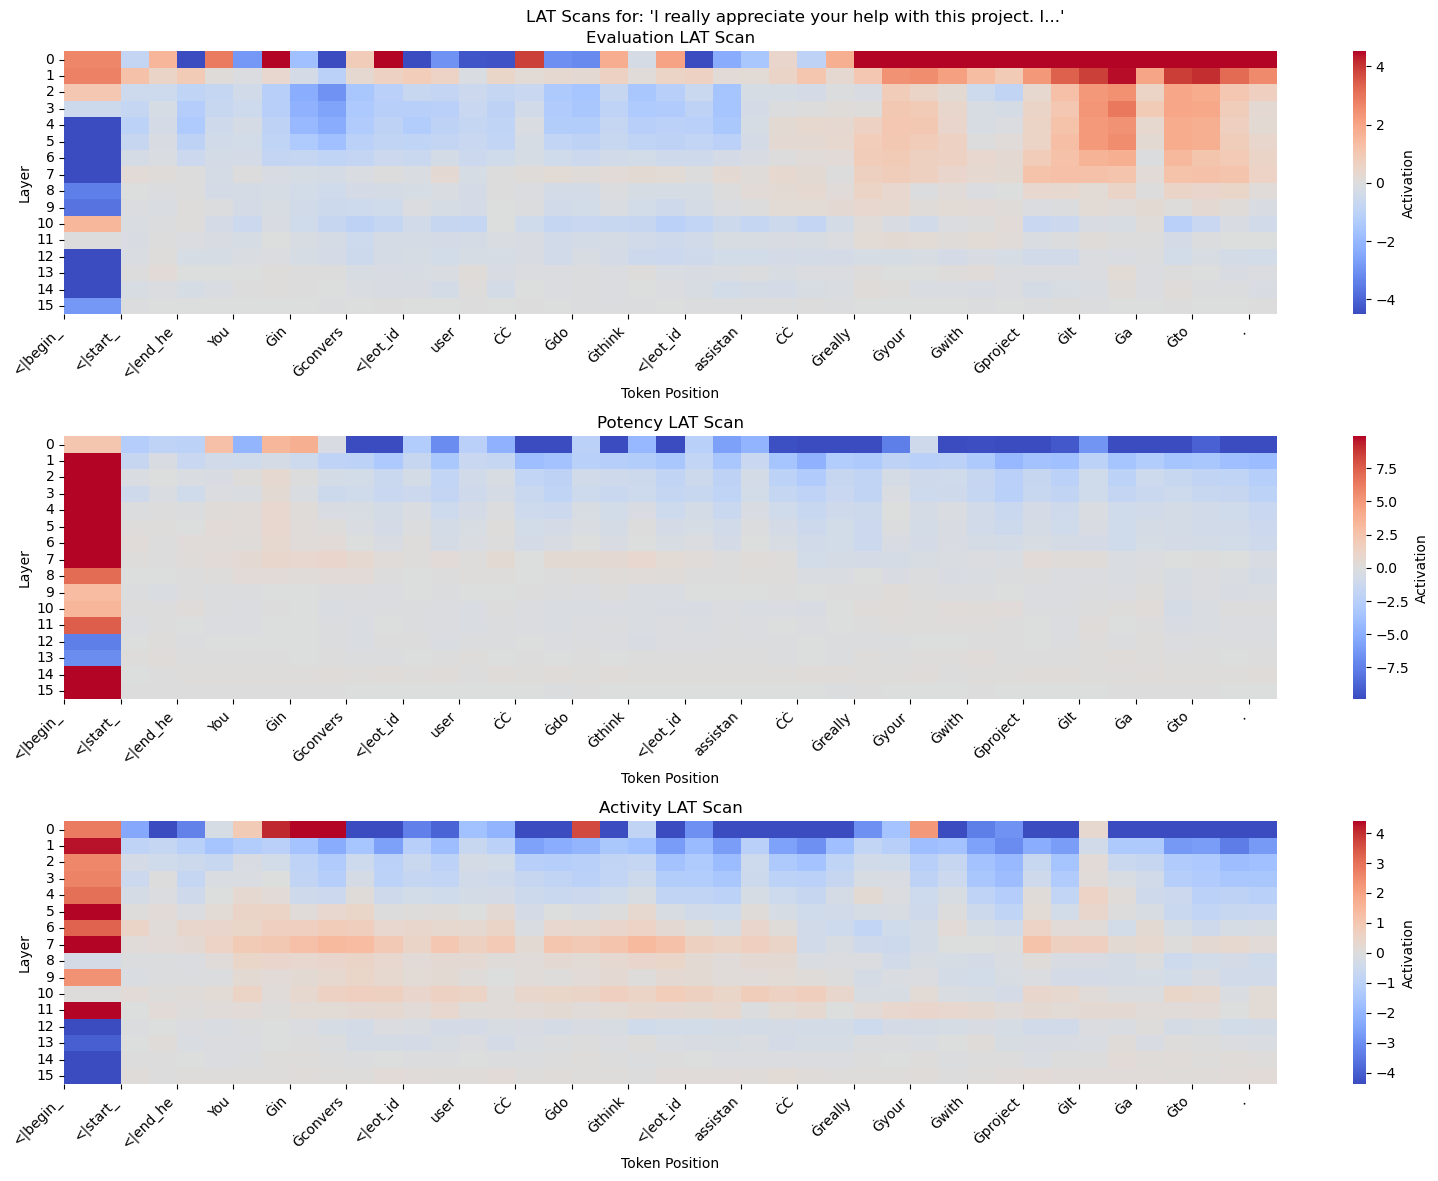

In [9]:
# Create LAT scans for each dimension
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Subset of layers for cleaner visualization
lat_layers = hidden_layers[::2]  # Every other layer

for ax, dimension in zip(axes, ["evaluation", "potency", "activity"]):
    tokens, scores_by_layer = get_per_token_scores(
        formatted, rep_readers[dimension], lat_layers
    )
    
    # Build matrix
    matrix = []
    for layer in sorted(lat_layers, reverse=True):  # Top = early layer
        matrix.append(scores_by_layer[layer])
    matrix = np.array(matrix)
    
    # Normalize
    bound = np.percentile(np.abs(matrix), 95)
    matrix = np.clip(matrix, -bound, bound)
    
    # Plot
    sns.heatmap(matrix, cmap='coolwarm', center=0,
                vmin=-bound, vmax=bound, ax=ax,
                cbar_kws={'label': 'Activation'})
    
    ax.set_xlabel("Token Position")
    ax.set_ylabel("Layer")
    ax.set_title(f"{dimension.capitalize()} LAT Scan")
    
    # Clean x-axis labels
    step = max(1, len(tokens) // 20)
    ax.set_xticks(np.arange(0, len(tokens), step))
    ax.set_xticklabels([tokens[i][:8] for i in range(0, len(tokens), step)], rotation=45, ha='right')

plt.suptitle(f"LAT Scans for: '{test_text[:50]}...'", fontsize=12)
plt.tight_layout()
plt.savefig("lat_scan_epa.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Per-Token Detection Visualization (Figure 9 Style)

Visualize token-by-token EPA intensity with colored text.

In [10]:
# Multiple test texts
test_texts = [
    "I really appreciate your help. Thank you so much for being there.",
    "This is absolutely unacceptable. I demand an explanation right now.",
    "Oh my gosh, this is so exciting! I can't wait to get started!",
    "I suppose we could try that. There's no rush, take your time.",
]

In [11]:
def plot_colored_text(tokens, scores, dimension, ax, title):
    """Plot colored text visualization."""
    dim_info = EPA_DIMENSIONS[dimension]
    
    # Clean tokens
    clean_tokens = []
    for token in tokens:
        t = token.replace('▁', ' ').replace('Ġ', ' ')
        t = t.replace('<|', '[').replace('|>', ']')
        clean_tokens.append(t)
    
    # Normalize scores
    scores = np.array(scores)
    scores = (scores - np.mean(scores)) / (np.std(scores) + 1e-8)
    mag = max(0.5, np.percentile(np.abs(scores), 90))
    scores = np.clip(scores, -mag, mag)
    
    # Colormap
    cmap = LinearSegmentedColormap.from_list('epa', ['#e74c3c', '#f5f5dc', '#27ae60'], N=256)
    norm = Normalize(vmin=-mag, vmax=mag)
    
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    x, y = 2, 8
    
    # Find assistant marker to start display
    start_idx = 0
    for i, t in enumerate(clean_tokens):
        if 'assistant' in t.lower():
            start_idx = i + 1
            break
    
    for i in range(start_idx, len(clean_tokens)):
        token = clean_tokens[i]
        score = scores[i] if i < len(scores) else 0
        
        if not token.strip():
            continue
        
        color = cmap(norm(score))
        
        text = ax.text(x, y, token, fontsize=9,
                      bbox=dict(facecolor=color, edgecolor='none', alpha=0.8, pad=0.5))
        
        # Estimate width
        x += len(token) * 0.8 + 1
        if x > 95:
            x = 2
            y -= 1.5
            if y < 1:
                break
    
    ax.set_title(title, fontsize=10, loc='left')

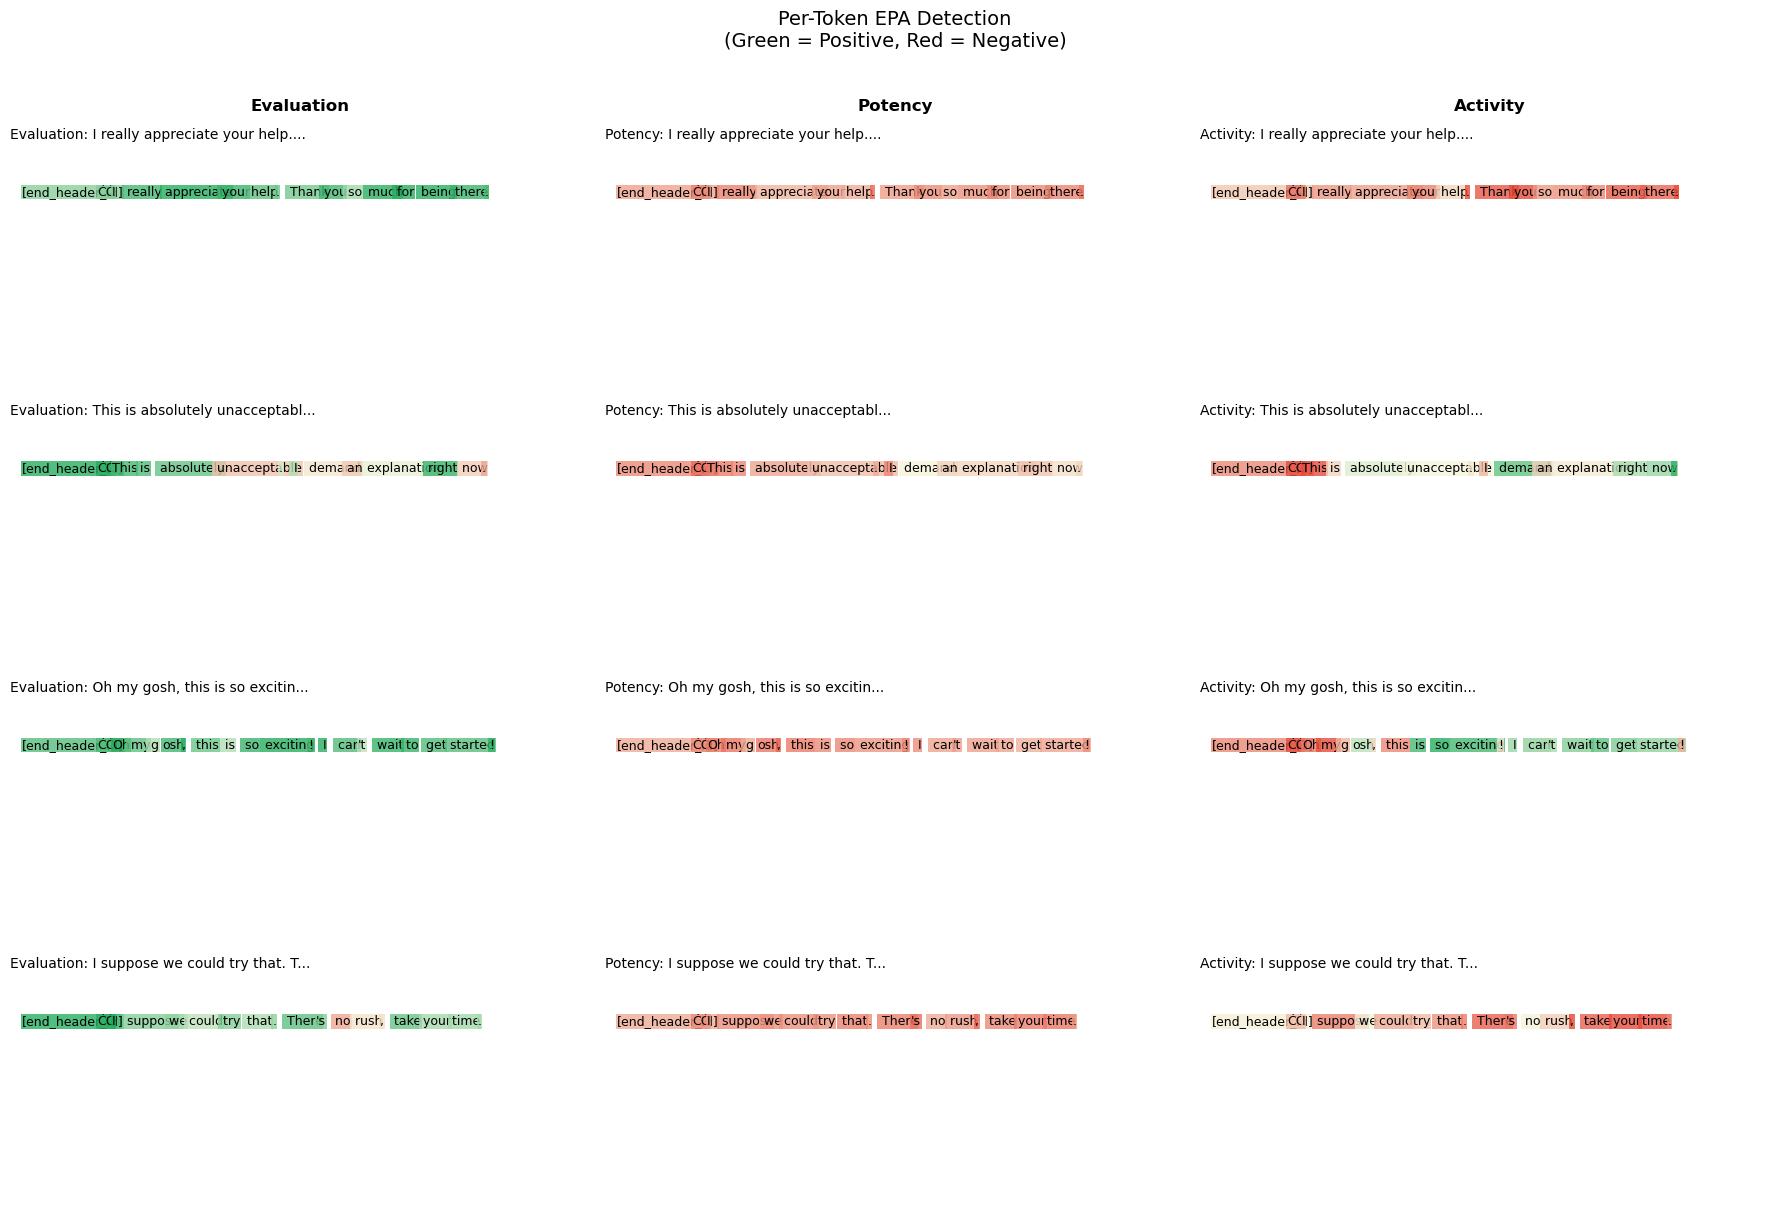

In [12]:
# Create per-token visualizations
fig, axes = plt.subplots(len(test_texts), 3, figsize=(18, 3*len(test_texts)))

# Use middle layers for detection
detection_layers = hidden_layers[len(hidden_layers)//4:len(hidden_layers)//2]

for row, text in enumerate(test_texts):
    formatted = format_for_reading(text)
    
    for col, dimension in enumerate(["evaluation", "potency", "activity"]):
        tokens, scores_by_layer = get_per_token_scores(
            formatted, rep_readers[dimension], detection_layers
        )
        
        # Average across layers
        avg_scores = np.mean([scores_by_layer[l] for l in detection_layers], axis=0)
        
        ax = axes[row, col]
        plot_colored_text(tokens, avg_scores, dimension, ax,
                         f"{dimension.capitalize()}: {text[:30]}...")

# Add column titles
for col, dim in enumerate(["Evaluation", "Potency", "Activity"]):
    axes[0, col].annotate(dim, xy=(0.5, 1.15), xycoords='axes fraction',
                         fontsize=12, fontweight='bold', ha='center')

plt.suptitle("Per-Token EPA Detection\n(Green = Positive, Red = Negative)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("per_token_epa.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Combined EPA Profile Visualization

In [13]:
def get_epa_profile(text):
    """Get EPA profile for text across layers."""
    formatted = format_for_reading(text)
    
    profiles = {}
    for dimension in ["evaluation", "potency", "activity"]:
        tokens, scores_by_layer = get_per_token_scores(
            formatted, rep_readers[dimension], hidden_layers
        )
        
        # Average over last few tokens and middle layers
        middle_layers = hidden_layers[len(hidden_layers)//4:len(hidden_layers)*3//4]
        layer_scores = [np.mean(scores_by_layer[l][-5:]) for l in middle_layers]
        profiles[dimension] = np.mean(layer_scores)
    
    return profiles

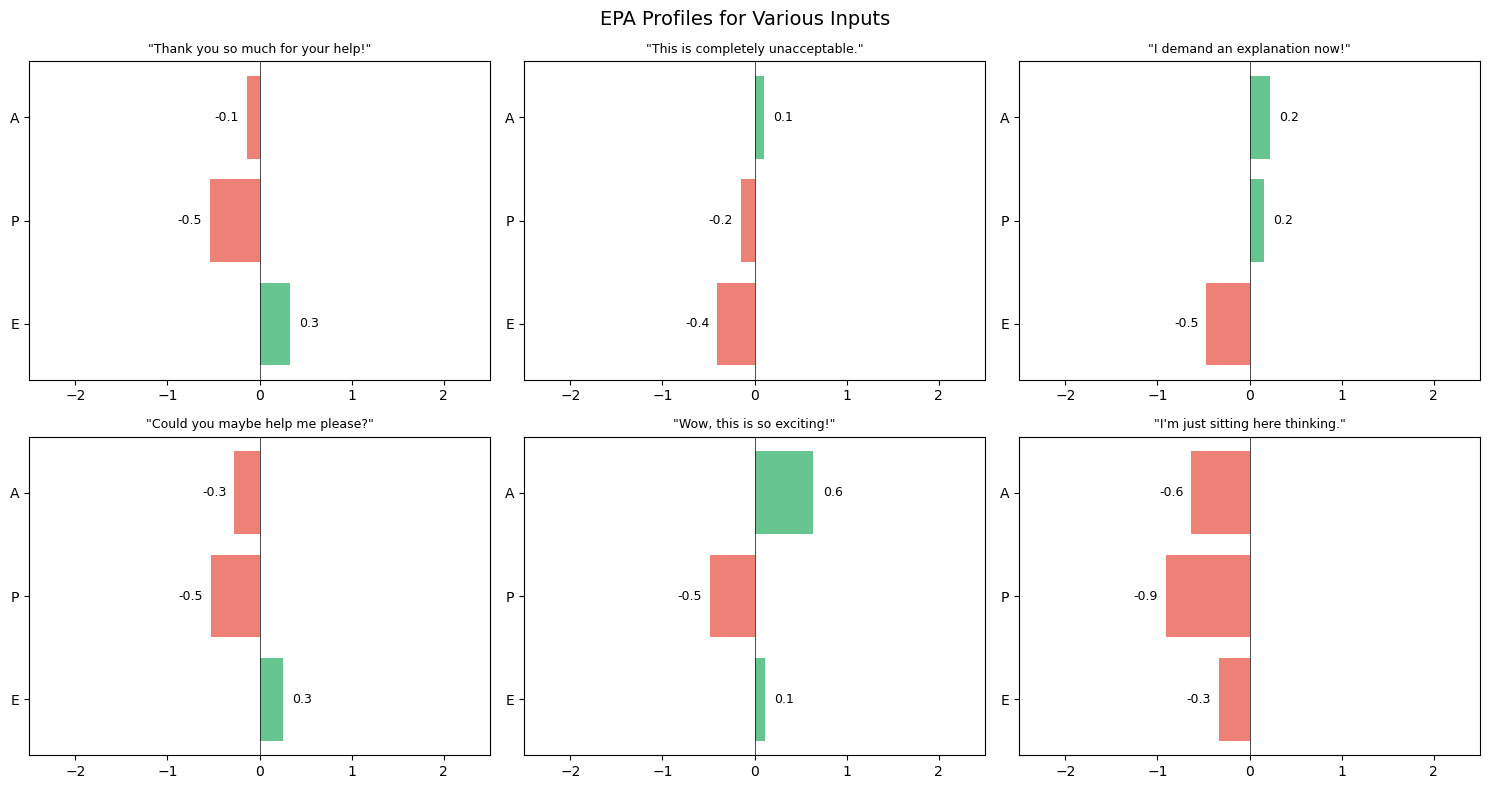

In [14]:
# EPA profiles for multiple inputs
profile_texts = [
    "Thank you so much for your help!",
    "This is completely unacceptable.",
    "I demand an explanation now!",
    "Could you maybe help me please?",
    "Wow, this is so exciting!",
    "I'm just sitting here thinking.",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, text in enumerate(profile_texts):
    profile = get_epa_profile(text)
    
    ax = axes[i]
    dims = ['E', 'P', 'A']
    vals = [profile['evaluation'], profile['potency'], profile['activity']]
    colors = ['#27ae60' if v > 0 else '#e74c3c' for v in vals]
    
    bars = ax.barh(dims, vals, color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlim(-2.5, 2.5)
    ax.set_title(f'"{text[:35]}..."' if len(text) > 35 else f'"{text}"', fontsize=9)
    
    # Add value labels
    for bar, val in zip(bars, vals):
        ax.text(val + 0.1 if val > 0 else val - 0.35, bar.get_y() + bar.get_height()/2,
               f'{val:.1f}', va='center', fontsize=9)

plt.suptitle("EPA Profiles for Various Inputs", fontsize=14)
plt.tight_layout()
plt.savefig("epa_profiles.png", dpi=150, bbox_inches='tight')
plt.show()

## Summary

This notebook demonstrated:

1. **t-SNE visualizations** showing EPA class separation in early vs late layers
2. **LAT scans** showing temporal activation patterns across layers
3. **Per-token detection** visualizations with colored text
4. **EPA profiles** for quick interpretation of input affect

Key findings:
- EPA concepts become more linearly separable in later layers
- LAT scans reveal layer-specific activation patterns
- Per-token visualization shows where EPA is most salient